# Part 2: Initial Portfolio Construction

**Objective**: Build and analyze an equal-weight portfolio from S&P 500 stocks.

**Tasks:**

1. Load preprocessed data from Part 1

2. Build equal-weight portfolio (w_i = 1/n)

3. Compute daily portfolio returns and simulate portfolio value

**Deliverables:**

- Daily portfolio returns time series

- Plot of portfolio value evolution from $100,000 initial investment

In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set plotting style
plt.style.use('default')

## Task 1: Load Preprocessed Data

In [26]:
# Load data from Part 1
data_dir = Path('../Part 1: Data Acquisition & Preprocessing')
prices = pd.read_csv(data_dir / 'sp500_prices_5yr.csv', 
                     index_col=0, parse_dates=True)
log_returns = pd.read_csv(data_dir / 'sp500_log_returns_5yr.csv', 
                          index_col=0, parse_dates=True)
tickers = list(prices.columns)
print(f'Loaded prices: {prices.shape}, log returns: {log_returns.shape}')

# Display the pre-loaded data
print("Displaying first 2 rows of the price data:")
print(prices.head(2))
print("Displaying first 2 rows of the log returns data:")
print(log_returns.head(2))

Loaded prices: (1254, 100), log returns: (1253, 100)
Displaying first 2 rows of the price data:
                  AAPL       GOOG      GOOGL        AMZN       AVGO  \
Date                                                                  
2020-08-07  108.203773  74.282959  74.471878  158.373001  28.915096   
2020-08-10  109.776505  74.362976  74.394836  157.408005  29.041964   

                 BRK-B        COST       ABBV        BAC        CVX  ...  \
Date                                                                 ...   
2020-08-07  209.479996  314.168213  75.978493  23.083563  69.710861  ...   
2020-08-10  212.580002  313.329590  75.536942  23.481400  72.063995  ...   

                 ACGL          A          BR        BRO        DXCM  \
Date                                                                  
2020-08-07  30.894695  94.532822  124.429184  44.604282  110.175003   
2020-08-10  31.122908  93.914055  125.671204  44.478371  105.305000   

                   STZ       

## Task 2: Build Equal-Weight Portfolio

In [27]:
# Build equal-weight portfolio
n = len(tickers)
weights = pd.Series(1.0 / n, index=tickers)
print(f'Equal weight per stock: {weights.iloc[0]:.4f}')

# Display portfolio weights
print("Displaying first 5 portfolio weights:")
print(weights.head(5))

Equal weight per stock: 0.0100
Displaying first 5 portfolio weights:
AAPL     0.01
GOOG     0.01
GOOGL    0.01
AMZN     0.01
AVGO     0.01
dtype: float64


## Task 3: Compute Portfolio Returns and Value

In [28]:
# Compute daily portfolio returns
portfolio_returns = log_returns.dot(weights)
# Simulate portfolio value from $100,000
initial_value = 100000

# Insert initial value at the first date
first_date = prices.index[0]
portfolio_returns_with_initial = portfolio_returns.copy()
portfolio_returns_with_initial.loc[first_date] = 0.0
portfolio_returns_with_initial = portfolio_returns_with_initial.sort_index()

portfolio_value = initial_value * (1 + portfolio_returns_with_initial).cumprod()
portfolio_value.iloc[0] = initial_value  # Ensure exact initial value

# Save results to CSV for downstream analysis
results = pd.DataFrame({
    'Portfolio_Return': portfolio_returns_with_initial,
    'Portfolio_Value': portfolio_value
})
results.to_csv('equal_weight_portfolio_results.csv')
print("Saved equal_weight_portfolio_results.csv")

# Display portfolio returns and values
print("Displaying first 5 rows of portfolio returns and values:")
print(results.head(5))
print("Displaying last 5 rows of portfolio returns and values:")
print(results.tail(5))

Saved equal_weight_portfolio_results.csv
Displaying first 5 rows of portfolio returns and values:
            Portfolio_Return  Portfolio_Value
Date                                         
2020-08-07          0.000000    100000.000000
2020-08-10          0.006132    100613.150620
2020-08-11         -0.002505    100361.130310
2020-08-12          0.007602    101124.066530
2020-08-13         -0.002229    100898.681586
Displaying last 5 rows of portfolio returns and values:
            Portfolio_Return  Portfolio_Value
Date                                         
2025-07-30         -0.002408    191362.349787
2025-07-31         -0.010245    189401.784426
2025-08-01         -0.014350    186683.858946
2025-08-04          0.011507    188831.973772
2025-08-05         -0.000849    188671.721949


## Deliverable 1: Daily Portfolio Returns Time Series

In [29]:
# Show first 5 rows
print("Displaying first 5 rows of portfolio returns:")
display(portfolio_returns.head())

Displaying first 5 rows of portfolio returns:


Date
2020-08-10    0.006132
2020-08-11   -0.002505
2020-08-12    0.007602
2020-08-13   -0.002229
2020-08-14    0.000762
dtype: float64

## Deliverable 2: Portfolio Value Plot

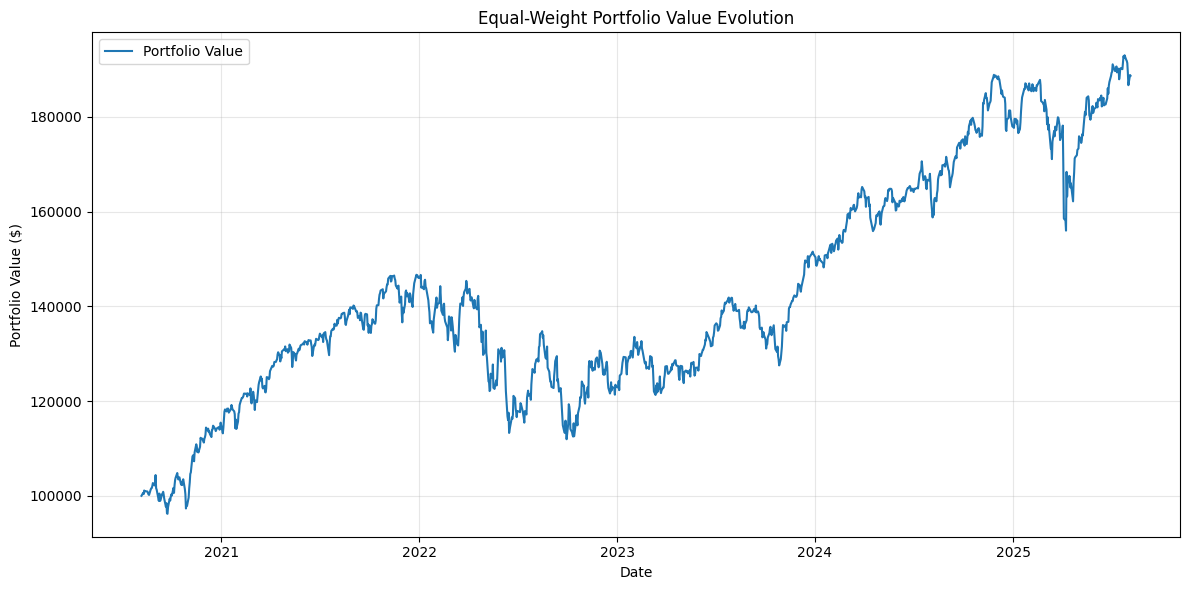

In [30]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.title('Equal-Weight Portfolio Value Evolution')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()